In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
import datetime

In [44]:
def date_parser(string):
    return datetime.datetime.fromtimestamp(int(string))

In [45]:
data = pd.read_csv("C:/Users/paulj/Documents/CompoundingCapital/ccplatform/ccplatform/coinbaseUSD.csv",names=['time','price','volume'],parse_dates=['time'],date_parser=date_parser)
data = data[-25000:]
print (data.head())
print (data.describe())

                        time    price    volume
18167817 2017-07-17 08:11:35  2050.60  0.940836
18167818 2017-07-17 08:11:38  2050.59  0.129000
18167819 2017-07-17 08:11:40  2050.59  0.174000
18167820 2017-07-17 08:11:40  2050.59  0.581000
18167821 2017-07-17 08:11:40  2050.59  0.010000
              price        volume
count  25000.000000  2.500000e+04
mean    2102.157888  4.707990e-01
std       66.806810  1.222110e+00
min     1976.000000  5.000000e-08
25%     2046.170000  1.000000e-02
50%     2122.000000  9.280250e-02
75%     2168.820000  4.028278e-01
max     2211.300000  3.836125e+01


Check the time difference between consecutive trades

In [46]:
alltimes = list(data.time)
timediffs = pd.DataFrame([(t - s).seconds for s, t in zip(alltimes, alltimes[1:])])
timediffs.describe()

,0
count,24999.000000
mean,1.708068
std,4.134352
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,50.000000


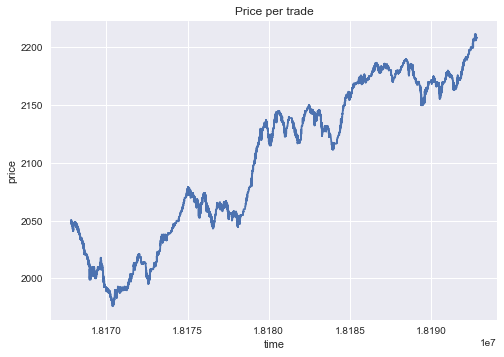

In [47]:
plt.plot(data.price)
plt.xlabel('time')
plt.ylabel('price')
plt.title('Price per trade')
plt.show()

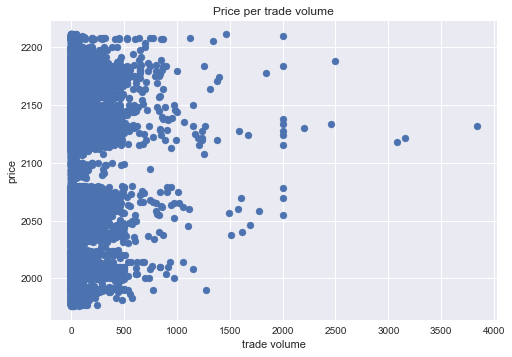

In [48]:
plt.scatter(data.volume*100,data.price)
plt.xlabel('trade volume')
plt.ylabel('price')
plt.title('Price per trade volume')
plt.show()

It seems that prices are highly affected by lagged prices over short period. we take lag till last 120 minutes of data (roughly 225 points) as regressor

In [49]:
LAG = 225
for i in range(1,LAG+1):
    var = 'price' + str(i)
    data[var] = data.price.shift(i)
data['target'] = data.price.shift(-1)    
data = data.dropna()    
data.target = data.target - data.price

In [50]:
print (data.shape)
print (data.head(3))

(24774, 229)
                        time    price    volume   price1   price2   price3  \
18168042 2017-07-17 08:16:50  2047.24  0.010000  2047.29  2047.23  2047.50   
18168043 2017-07-17 08:16:52  2047.50  1.976436  2047.24  2047.29  2047.23   
18168044 2017-07-17 08:16:53  2047.42  0.012000  2047.50  2047.24  2047.29   

           price4   price5   price6   price7   ...    price217  price218  \
18168042  2047.50  2047.23  2047.24  2047.50   ...     2050.60   2050.61   
18168043  2047.50  2047.50  2047.23  2047.24   ...     2050.61   2050.60   
18168044  2047.23  2047.50  2047.50  2047.23   ...     2050.52   2050.61   

          price219  price220  price221  price222  price223  price224  \
18168042   2050.60   2050.60   2050.59   2050.59   2050.59   2050.59   
18168043   2050.61   2050.60   2050.60   2050.59   2050.59   2050.59   
18168044   2050.60   2050.61   2050.60   2050.60   2050.59   2050.59   

          price225  target  
18168042   2050.60    0.26  
18168043   2050.59   -

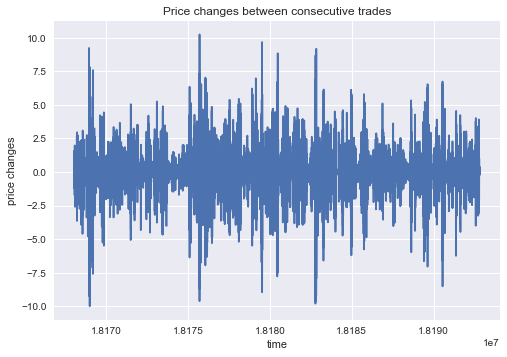

buy limit is USD 0.0499999999997
sell limit is USD -0.0300000000002


In [51]:
plt.plot(data.target)
plt.xlabel('time')
plt.ylabel('price changes')
plt.title('Price changes between consecutive trades')
plt.show()

data.target.describe()
buy_limit = np.percentile(data.target, 75)
sell_limit = np.percentile(data.target, 25)
print ("buy limit is USD", buy_limit)
print ("sell limit is USD", sell_limit)

we will predict target variable (price change between consecutive trades) using lagged prices and traded volume

In [52]:
import math
train = data.iloc[:math.floor(data.shape[0]*.75)].reset_index(drop=True)
test = data.iloc[math.ceil(data.shape[0]*.75):].reset_index(drop=True)
del data

In [53]:
regressors1 = [i for i in train.columns if i == 'price' or ('price' in i and int(i.replace('price','')) <= 225)]
regressors2 = [i for i in train.columns if i == 'price' or ('price' in i and int(i.replace('price','')) <= 120)]
regressors3 = [i for i in train.columns if i == 'price' or ('price' in i and int(i.replace('price','')) <= 60)]

In [54]:
clf = BayesianRidge(compute_score=True,normalize=True)
clf.fit(train[regressors1],train.target)
ols = LinearRegression(normalize=True)
ols.fit(train[regressors1],train.target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [55]:
clf_pred = clf.predict(test[regressors1])
ols_pred = ols.predict(test[regressors1])

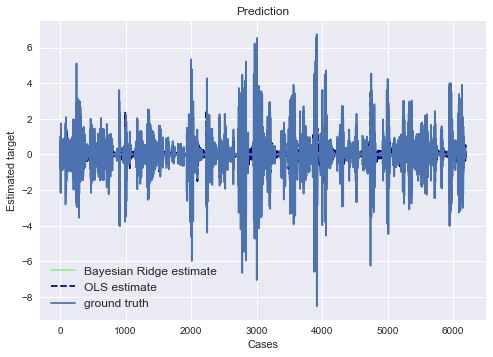

In [56]:
plt.title("Prediction")
plt.plot(clf_pred, color='lightgreen', label="Bayesian Ridge estimate")
plt.plot(ols_pred, color='navy', linestyle='--', label="OLS estimate")
plt.plot(test.target, label = 'ground truth')
plt.xlabel("Cases")
plt.ylabel("Estimated target")
plt.legend(loc="best", prop=dict(size=12))
plt.show()

In [57]:
clf = BayesianRidge(compute_score=True,normalize=True)
clf.fit(train[regressors1],train.target)
train['pred1'] = clf.predict(train[regressors1])
test['pred1'] = clf.predict(test[regressors1])

clf = BayesianRidge(compute_score=True,normalize=True)
clf.fit(train[regressors2],train.target)
train['pred2'] = clf.predict(train[regressors2])
test['pred2'] = clf.predict(test[regressors2])

clf = BayesianRidge(compute_score=True,normalize=True)
clf.fit(train[regressors3],train.target)
train['pred3'] = clf.predict(train[regressors3])
test['pred3'] = clf.predict(test[regressors3])

In [58]:
new_regressors = ['volume','price','pred1','pred2','pred3']
train[new_regressors+['target']].head(5)

,volume,price,pred1,pred2,pred3,target
0,0.010000,2047.24,0.040614,0.126992,0.078671,0.26
1,1.976436,2047.50,-0.122527,-0.152997,-0.109856,-0.08
2,0.012000,2047.42,-0.066485,0.033807,0.049514,0.08
3,0.080800,2047.50,-0.145870,-0.146406,-0.085489,0.00
4,2.042784,2047.50,0.116956,0.081356,0.019955,0.00


We see for some periods the price difference predictions are quite accurate. Ensemble can boost performance in this case.

In [59]:
clf = BayesianRidge(compute_score=True,normalize=True,fit_intercept=True)
clf.fit(train[new_regressors],train.target)
pred = clf.predict(test[new_regressors])

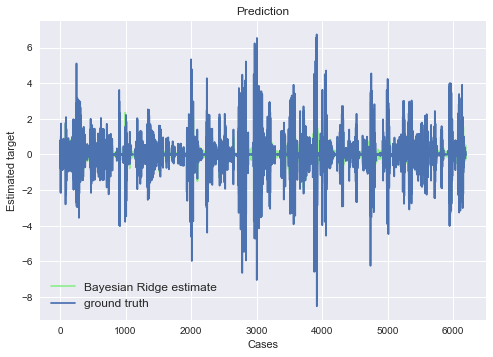

In [60]:
plt.title("Prediction")
plt.plot(pred, color='lightgreen', label="Bayesian Ridge estimate")
plt.plot(test.target, label = 'ground truth')
plt.xlabel("Cases")
plt.ylabel("Estimated target")
plt.legend(loc="best", prop=dict(size=12))
plt.show()

Lets formulate a basic trading strategy. When current position is <= 0 and price diff >= buy limit we buy. If current
position is >= 0 and price diff <= sell limit we sell. Else we hold the position.

In [61]:
def backtest(pred,actual_price,current_pos=0,cum_profit=0,current_balance=0):
    profit = []
    balance = []
    for index, i in enumerate(pred):
        if i >= buy_limit and current_pos <= 0:
            current_pos = 1
            buy_price = actual_price[index]
            current_balance -= buy_price
        if i <= sell_limit and current_pos == 1:
            current_pos = 0
            sell_price = actual_price[index] 
            current_balance += sell_price
            cum_profit = current_balance
        profit.append(cum_profit)
        balance.append(current_balance)
    return balance, profit    

In [62]:
balance, profit = backtest(pred,list(test.price))

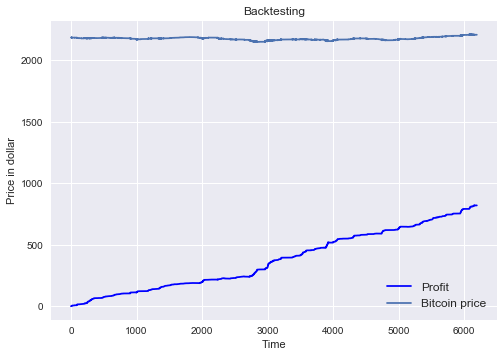

In [63]:
plt.title("Backtesting")
plt.plot(profit, color='blue', label="Profit")
plt.plot(test.price, label = 'Bitcoin price')
plt.xlabel("Time")
plt.ylabel("Price in dollar")
plt.legend(loc="best", prop=dict(size=12))
plt.show()

In [64]:
print ("max profit at", test.time.iloc[profit.index(max(profit))], "with profit of USD ", max(profit), "and bitcoin price USD ",test.price.iloc[profit.index(max(profit))]) 
print ("profit at", test.time.iloc[0], "with profit of USD ", profit[0], "and bitcoin price USD ",test.price.iloc[0])
print ("profit at", test.time.iloc[-1], "with profit of USD ", profit[-1], "and bitcoin price USD ",test.price.iloc[-1])

max profit at 2017-07-17 20:02:30 with profit of USD  820.14 and bitcoin price USD  2208.51
profit at 2017-07-17 17:42:01 with profit of USD  0 and bitcoin price USD  2185.94
profit at 2017-07-17 20:03:13 with profit of USD  820.14 and bitcoin price USD  2208.47


We see some profit over time. Net profit is 47$ (20%) for a single bitcoin trading over the trading period of one day. 